In [1]:
# Ignore warnings
import warnings

# warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)

from typing import Optional, Tuple, Any

from samna.dynapse2 import *
import samna

# Utils
import numpy as np
from tqdm import tqdm
import time

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.modules.jax import LIFJax
from rockpool.nn.combinators import Sequential

# DynapSE
from rockpool.devices.dynapse.dynapsim import DynapSim
from rockpool.devices.dynapse.utils.figure import Figure
from rockpool.devices.dynapse.utils.spike_input import poisson_spike_train
from rockpool.nn.modules.module import ModuleBase
# from rockpool.devices.dynapse.ref.weights_old import WeightParameters
from rockpool.devices.dynapse.quantize.weight_handler import WeightHandler

## Dynap-SE2
from rockpool.devices.dynapse.config.simconfig import DynapSimConfig
from rockpool.devices.dynapse.samna_alias import dynapse2 as ds2
from rockpool.devices.dynapse.interface.utils import find_dynapse_boards, configure_dynapse2_fpga, disconnect, raster_to_aer, capture_events_from_device
from rockpool.devices.dynapse.interface.samna import DynapseSamna

# - Plotting and config
import matplotlib.pyplot as plt

# %matplotlib inline
plt.rcParams["figure.figsize"] = [5.6, 2.8]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
T = 500
c = 60
spike_train  = np.random.poisson(0.02, (T,c)).astype(bool)

In [3]:
with open("./frozen_noise_classification/win.npy", "rb") as f:
    w_in = np.load(f)

with open("./frozen_noise_classification/wrec.npy", "rb") as f:
    w_rec = np.load(f)

with open("./frozen_noise_classification/mux_in.npy", "rb") as f:
    mux_in = np.load(f)

with open("./frozen_noise_classification/mux_rec.npy", "rb") as f:
    mux_rec = np.load(f)

with open("./frozen_noise_classification/Iw.npy", "rb") as f:
    Iw = np.load(f)

In [4]:
qmux_in = WeightHandler.int2bit_mask(4, mux_in).T
qmux_in.shape

(2, 60, 4)

In [5]:
qmux_rec = WeightHandler.int2bit_mask(4, mux_rec).T
qmux_rec.shape

(2, 2, 4)

In [6]:
## Utils
def set_parameter(parameters, name, coarse, fine):
    parameter = parameters[name]
    parameter.coarse_value = coarse
    parameter.fine_value = fine


## Connect to device
se2_devices = find_dynapse_boards()

INFO:root: Total of 1 DYNAP-SE2 board(s) found with serial numbers : ['']


In [7]:
found_se2 = len(se2_devices) > 0

if not found_se2:
    raise IOError('This tutorial requires a connected Dynap-SE2 Stack Board HDK to demonstrate.')
else:
    # board = configure_dynapse2_fpga(se2_devices[0])
    se2_stack = se2_devices[0]

In [8]:
print("Configuring parameters")

simconfig = DynapSimConfig(Iw_0=Iw[0], Iw_1=Iw[1], Iw_2=Iw[2], Iw_3=Iw[3])
param_dict = simconfig.export_Dynapse2Parameters()
se2 = DynapseSamna((60,2), se2_stack)

## Get model config
myConfig = se2.config
## Configure Parameters Manually
# [] TODO : All at once


for key, value in param_dict.items():
    set_parameter(myConfig.chips[0].cores[0].parameters, key, *value)
    print(key, value)

set_parameter(myConfig.chips[0].cores[0].parameters, "SOAD_CASC_P", 5, 254)

Configuring parameters


ValueError: ERROR: initializeUSB failed, error code : -3

In [ ]:
cam_weights_in = qmux_in
syn_type_in = (w_in > 0).T

cam_weights_rec = qmux_rec
syn_type_rec = (w_rec > 0).T

In [ ]:
print("Configuring cams")

cams0 = [Dynapse2Synapse() for _ in range(64)]
cams1 = [Dynapse2Synapse() for _ in range(64)]

# Neuron 0
for i in range(60):

    # set CAM -- synapses
    cams0[i].tag = 1024 + i
    cams0[i].dendrite = Dendrite.ampa if syn_type_in[0,i] else Dendrite.gaba
    cams0[i].weight = cam_weights_in[0,i]

# REC
cams0[60].tag = 2000
cams0[60].dendrite = Dendrite.ampa if syn_type_rec[0,0] else Dendrite.gaba
cams0[60].weight = cam_weights_rec[0,0]

cams0[61].tag = 2001
cams0[61].dendrite = Dendrite.ampa if syn_type_rec[0,1] else Dendrite.gaba
cams0[61].weight = cam_weights_rec[0,1]


# Neuron 1
for i in range(60):

    # set CAM -- synapses
    cams1[i].tag = 1024 + i
    cams1[i].dendrite = Dendrite.ampa if syn_type_in[1,i] else Dendrite.gaba
    cams1[i].weight = cam_weights_in[1,i]

# REC
cams1[60].tag = 2002
cams1[60].dendrite = Dendrite.ampa if syn_type_rec[1,0] else Dendrite.gaba
cams1[60].weight = cam_weights_rec[1,0]

cams1[61].tag = 2003
cams1[61].dendrite = Dendrite.ampa if syn_type_rec[1,1] else Dendrite.gaba
cams1[61].weight = cam_weights_rec[1,1]

myConfig.chips[0].cores[0].neurons[27].synapses = cams0
myConfig.chips[0].cores[0].neurons[28].synapses = cams1

Configuring cams


In [ ]:
print("Configuring srams")

destinations0 = [Dynapse2Destination() for _ in range(4)]

destinations0[0].tag = 2021
destinations0[0].core = [True, False, False, False,]
destinations0[0].x_hop = -1

destinations0[1].tag = 2000
destinations0[1].core = [True, False, False, False,]

destinations0[2].tag = 2001
destinations0[2].core = [True, False, False, False,]

myConfig.chips[0].cores[0].neurons[27].destinations = destinations0


destinations1 = [Dynapse2Destination() for _ in range(4)]
destinations1[0].tag = 2022
destinations1[0].core = [True, False, False, False,]
destinations1[0].x_hop = -1

destinations1[1].tag = 2002
destinations1[1].core = [True, False, False, False,]

destinations1[2].tag = 2003
destinations1[2].core = [True, False, False, False,]

myConfig.chips[0].cores[0].neurons[28].destinations = destinations1

se2.config = myConfig
time.sleep(1)

Configuring srams


In [ ]:
channel_map = {
    i: ds2.Dynapse2Destination(
        core=[True, False, False, False], x_hop=0, y_hop=0, tag=1024 + i
    )
    for i in range(64)
}

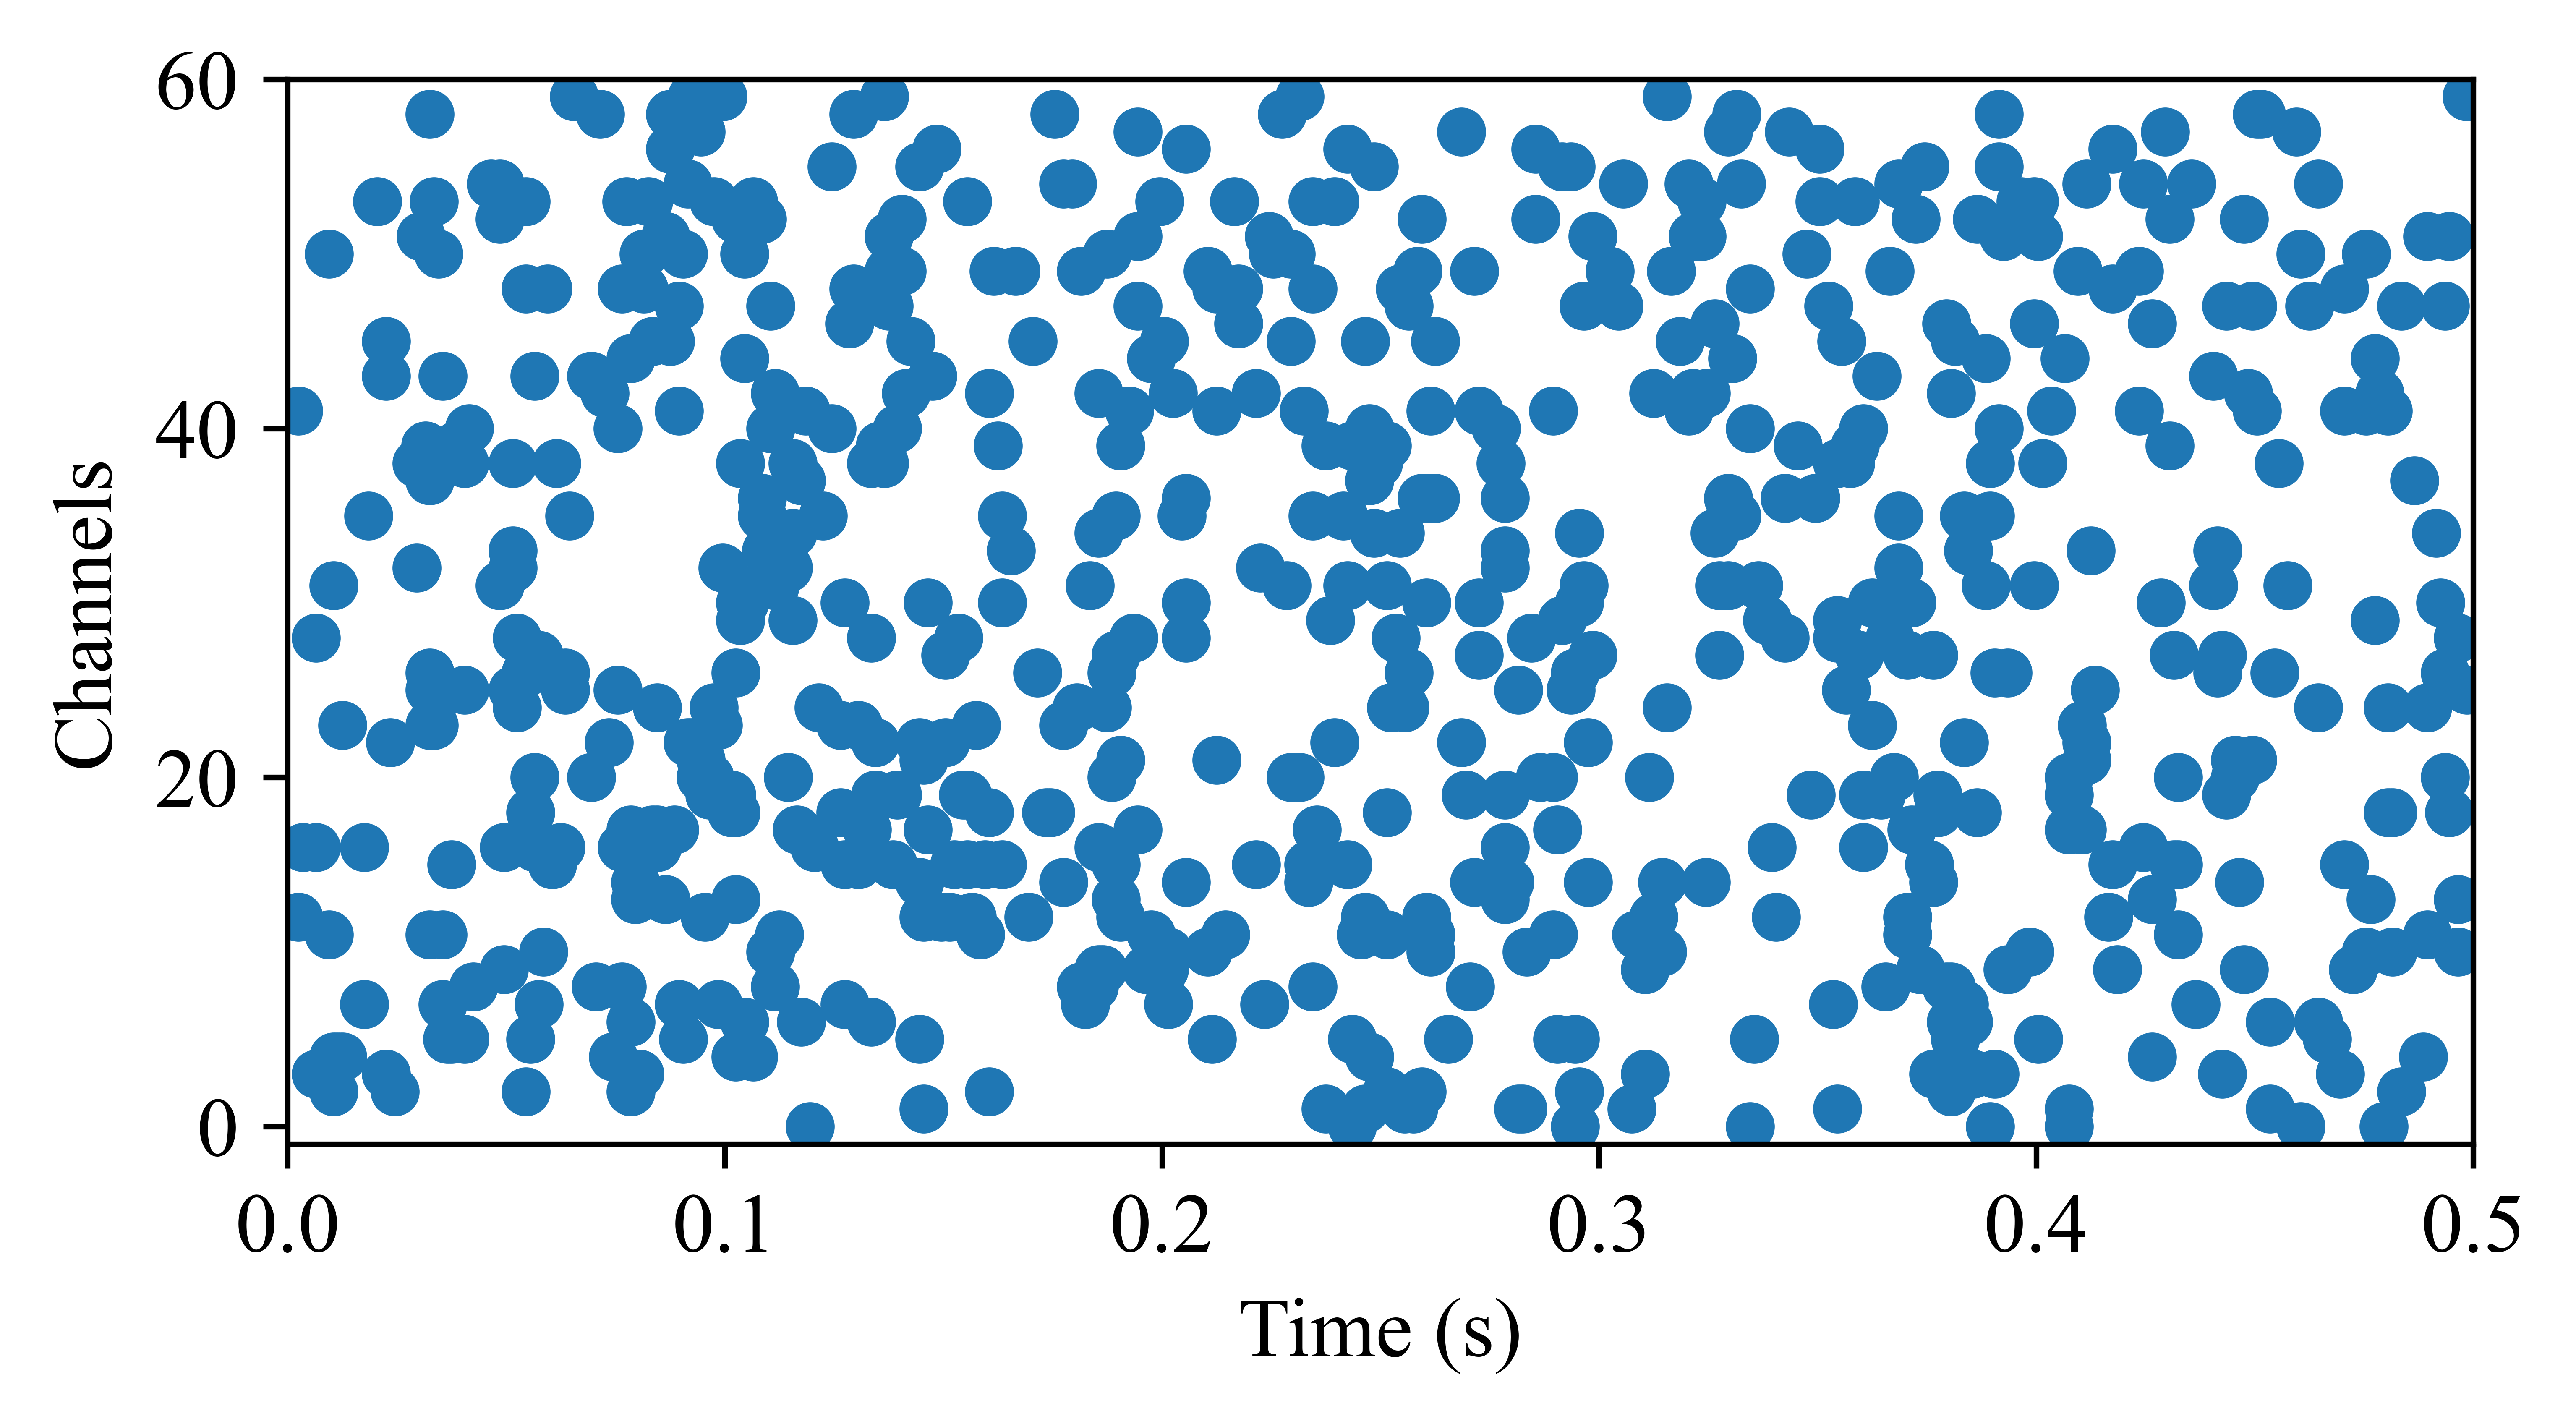

In [ ]:
TSEvent.from_raster(spike_train, 1e-3).plot()

In [ ]:
out, states, _ = se2(spike_train, channel_map=channel_map)

In [ ]:
states

{'channel_map': {0: Dynapse2Destination(core=[True, False, False, False], x_hop=0, y_hop=0, tag=2022),
  1: Dynapse2Destination(core=[True, False, False, False], x_hop=0, y_hop=0, tag=2021)},
 'input_start_time': 2.798354,
 'input_stop_time': 3.298354,
 'record_start_time': 2.8074559999999997,
 'record_stop_time': 3.259166}

In [ ]:
out.shape

(452, 2)

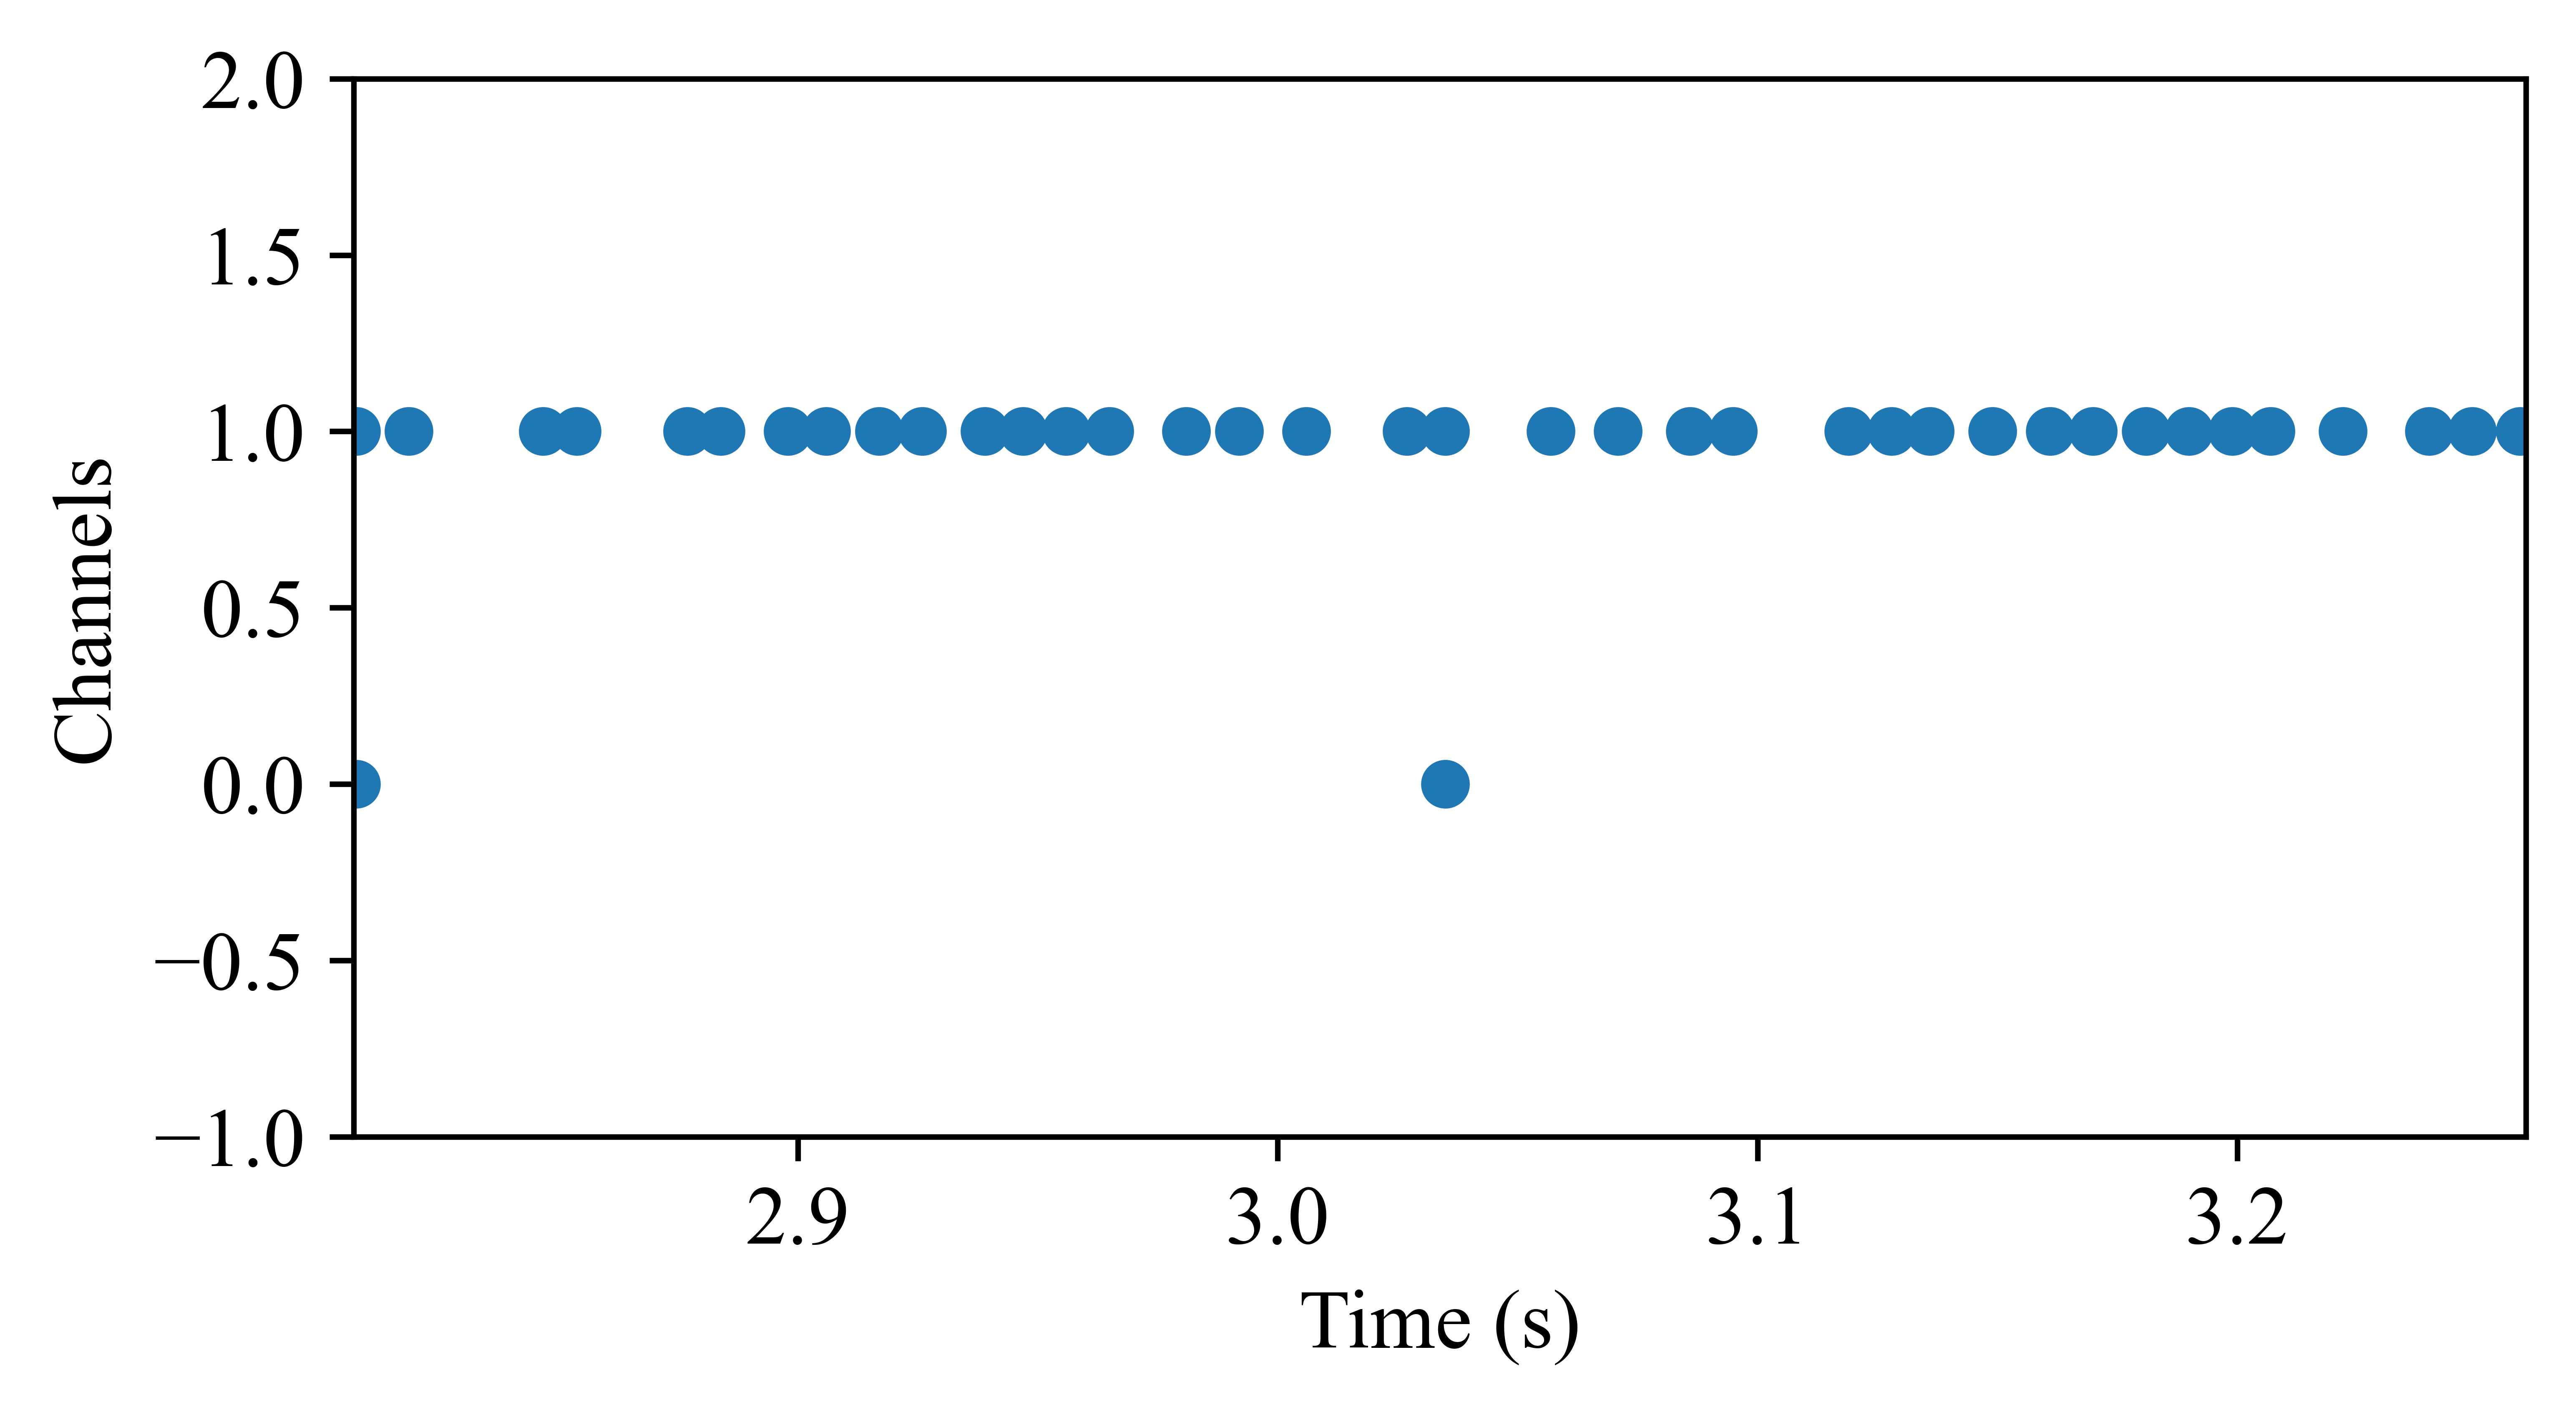

In [ ]:
TSEvent.from_raster(out, dt=1e-3, t_start=states['record_start_time'], t_stop=states['record_stop_time']+1e-3).plot()

In [ ]:
se2.config

In [ ]:
myConfig

In [ ]:
dir(myConfig)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'chips',
 'from_json',
 'to_json']

In [ ]:
from rockpool.devices.dynapse.samna_alias.dynapse2 import Dynapse2Configuration

ImportError: cannot import name 'Dynapse2Configuration' from 'rockpool.devices.dynapse.samna_alias.dynapse2' (/Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/dynapse/samna_alias/dynapse2.py)